In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tsmoothie.smoother import LowessSmoother
from joblib import Parallel, delayed

set里是vec; kalman;注释;idprofit

In [2]:
df = pd.read_excel('数据示例.xlsx',header=None)
df.rename(columns={0:'Date',1:'F1',2:'F2'},inplace=True)
df.set_index('Date',inplace=True)

In [3]:
class time_seires_analysis():

    def __init__(self,ts1,ts2,weights=None) -> None:
        # input: 同等shape的两个时间序列
        # weights： 时间序列横截面权重
        self.ts1 = np.asarray(ts1)
        self.ts2 = np.asarray(ts2)
        self.weights = weights
        if self.ts1.shape != self.ts2.shape:
            raise Exception('Unequal shape of time series')

    global do_smooth

    def do_smooth(ts,k=15):
        # input：一维时间序列
        # k：期望趋势变点个数
        # output：平滑时间序列
        for sf in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            smoother = LowessSmoother(smooth_fraction=sf, iterations=2)
            smoother.smooth(ts)
            sig = np.sign(np.diff(smoother.smooth_data[0]))
            cp = 0
            for i in range(len(sig)-1):
                if sig[i+1] != sig[i]:
                    cp += 1
            if cp <= k:
                # print('smooth fraction is {}'.format(sf))
                break
        return smoother.smooth_data[0]
    
    global do_tendancy

    def do_tendancy(ts):
        # input：一维时间序列
        # output：时间序列趋势序列
        return np.sign(np.diff(ts))
    
    global do_accuracy

    def do_accuracy(x,y):
        # input：两个同等长度一维趋势序列
        # output：两个序列趋势一致性
        if len(x) != len(y):
            raise Exception('Unequal shape of time series')
        distance = 0
        for i in range(len(x)):
            if x[i] == y[i]:
                distance += 1
        return distance/len(x)
    
    global do_compare
    
    def do_compare(ts1,ts2,weights=None):
        # input: 同等shape的两个时间序列
        # weights： 时间序列横截面权重
        # output：时间序列趋势一致性
        if len(ts1.shape) == 1:
            ss1 = do_smooth(ts1)
            ss2 = do_smooth(ts2)
            td1 = do_tendancy(ss1)
            td2 = do_tendancy(ss2)
            return do_accuracy(td1,td2)
        else:
            n = td1.shape[1]
            def subjob_func(i):
                x = [a[i] for a in td1]
                y = [a[i] for a in td2]
                ss1 = do_smooth(x)
                ss2 = do_smooth(y)
                td1 = do_tendancy(ss1)
                td2 = do_tendancy(ss2)
                return do_accuracy(x,y)
            res = Parallel(n_jobs=-1)(delayed(subjob_func)(i) for i in range(n))
            if not weights:
                return np.mean(res)
            return np.dot(res,weights)
    
    def compare(self):
        return do_compare(ts1=self.ts1,ts2=self.ts2,weights=self.weights)

    def leadlag(self,l=12):
        # input：最大滞后阶数
        # output：按趋势一致性指标排序后的滞后阶数字典
        ll = {}
        for i in range(1,l):
            temp1 = self.ts1[:-i]
            temp2 = self.ts2[i:]
            ll['F2-LAG-F1-{}阶'.format(i)] = do_compare(temp1,temp2,weights=self.weights)
        return sorted(ll.items(),key=lambda x:x[1])
    
    def plot(self,smooth=False,lag=0):
        if smooth:
            plt.plot(do_smooth(pd.DataFrame(self.ts1)),label='F1')
            plt.plot(do_smooth(pd.DataFrame(self.ts2).shift(-lag).dropna()),label='F2')
            plt.legend()
            plt.show()
        else:
            plt.plot(pd.DataFrame(self.ts1),label='F1')
            plt.plot(pd.DataFrame(self.ts2).shift(-lag).dropna(),label='F2')
            plt.legend()
            plt.show()

In [4]:
tsa = time_seires_analysis(df.F1,df.F2)
tsa.leadlag()

[('F2-LAG-F1-1阶', 0.5776173285198556),
 ('F2-LAG-F1-2阶', 0.6159420289855072),
 ('F2-LAG-F1-3阶', 0.6472727272727272),
 ('F2-LAG-F1-4阶', 0.6788321167883211),
 ('F2-LAG-F1-5阶', 0.7032967032967034),
 ('F2-LAG-F1-11阶', 0.7228464419475655),
 ('F2-LAG-F1-6阶', 0.7316176470588235),
 ('F2-LAG-F1-10阶', 0.7388059701492538),
 ('F2-LAG-F1-7阶', 0.7601476014760148),
 ('F2-LAG-F1-8阶', 0.774074074074074),
 ('F2-LAG-F1-9阶', 0.7769516728624535)]

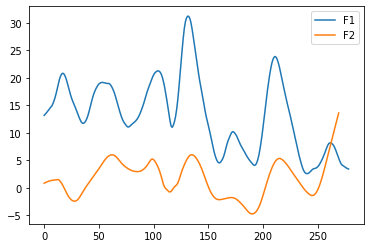

In [5]:
tsa.plot(smooth=True,lag=9)

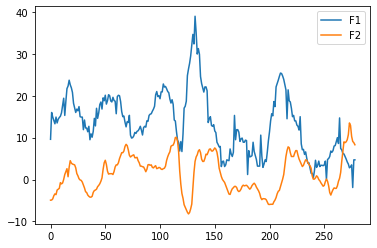

In [6]:
tsa.plot(smooth=False,lag=0)